# Convolutional network

Here, we examine the performance of CNN's on our dataset. The goal is to examine performance in situation where graph information is not refined, that is we keep all FC links.

In [1]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

## Load data

In [67]:
DATA_FOLDER = '../data'
PICKLE_FOLDER = '../pickles'

In [68]:
with open(f'{PICKLE_FOLDER}/fc-pearson.pickle', 'rb') as f:
    fc_pearson = pickle.load(f)

In [69]:
with open(f'{PICKLE_FOLDER}/fc-spearman.pickle', 'rb') as f:
    fc_spearman = pickle.load(f)

In [70]:
df_metadata = pd.read_csv(f'{DATA_FOLDER}/patients-cleaned.csv', index_col=0)

In [71]:
df_metadata.head(2)

,age,sex,target
0,24.750,1,0
1,27.667,1,0


## Split data

In [72]:
with open(f'{PICKLE_FOLDER}/test-indices.pickle', 'rb') as f:
    test_indices = pickle.load(f)

### Select the dataset to work with.

In [78]:
fc = fc_pearson.copy()

In [79]:
total_samples, total_brain_regions, _ = fc.shape

In [80]:
X_test_numpy = fc[test_indices]
y_test_numpy = df_metadata.iloc[test_indices]["target"].reset_index(drop=True)

In [81]:
train_indices = ~np.isin(np.arange(total_samples), test_indices)
X_train_numpy = fc[train_indices]
y_train_numpy = df_metadata.iloc[train_indices]["target"].reset_index(drop=True)

We will be using LOOCV to get validation performance of our models.

## Augment data

In [83]:
# Zero auto-correlations.
for i in range(total_brain_regions):
    X_train_numpy[:, i, i] = 0
    X_test_numpy[:, i, i] = 0

For some reason zeroing auto-correlations renders the model unconvergable.

## Prepare data

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [85]:
X_train = torch.from_numpy(X_train_numpy).unsqueeze(1).to(device, dtype=torch.float32)
X_test = torch.from_numpy(X_test_numpy).unsqueeze(1).to(device, dtype=torch.float32)

y_train = torch.from_numpy(y_train_numpy.values).unsqueeze(1).to(device, dtype=torch.float32)
y_test = torch.from_numpy(y_test_numpy.values).unsqueeze(1).to(device, dtype=torch.float32)

In [86]:
trainloader = torch.utils.data.DataLoader([*zip(X_train, y_train)], batch_size=4, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader([*zip(X_test, y_test)], batch_size=4, shuffle=False, num_workers=0)

## Define model

In [87]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(1,3), padding=(0,1))
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,3), padding=(0,1))
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(1,3), padding=(0,1))
        
        self.pool = nn.MaxPool2d(kernel_size=(1,2), stride=1)

        self.fc1 = nn.Linear(in_features=1 * 90 * 87, out_features=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 1 * 90 * 87)

        x = F.softmax(self.fc1(x), dim=-1)      # torch.sigmoid with fc1 out=1
        return x

In [88]:
net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(1, 3, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (conv2): Conv2d(3, 3, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (conv3): Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (pool): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7830, out_features=2, bias=True)
)

In [89]:
optimizr = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCELoss()

## Model training

In [90]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True) # Gives us 7 folds split (120 : 20).

In [91]:
for kfold, (train_index, val_index) in enumerate(skf.split(X_train_numpy, y_train_numpy)):
    # Init model.
    net = ConvNet()
    net.to(device)
    optimizr = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss() # nn.BCELoss()

    # Prepare data.
    X_train = torch.from_numpy(X_train_numpy[train_index]).unsqueeze(1).to(device, dtype=torch.float32)
    X_val = torch.from_numpy(X_train_numpy[val_index]).unsqueeze(1).to(device, dtype=torch.float32)

    y_train = torch.from_numpy(y_train_numpy[train_index].values).unsqueeze(1).to(device, dtype=torch.float32)
    y_val = torch.from_numpy(y_train_numpy[val_index].values).unsqueeze(1).to(device, dtype=torch.float32)
    print(f'Train set: {y_train.sum() / y_train.size(0):.2f}, val set: {y_val.sum() / y_val.size(0):.2f}')
    trainloader = torch.utils.data.DataLoader([*zip(X_train, y_train)], batch_size=4, shuffle=True,num_workers=0)
    valloader = torch.utils.data.DataLoader([*zip(X_val, y_val)], batch_size=4, shuffle=False, num_workers=0)

    # Train.
    for epoch in range(300):
        running_loss = 0.

        for i, (images, labels) in enumerate(trainloader, 0):

            optimizr.zero_grad()
            outputs = net.forward(images)
            loss = criterion(outputs, labels.squeeze(-1).to(torch.long))
            loss.backward()

            optimizr.step()

            # running_loss += loss.item()
            # if i % 10 == 9:
            #     print(f'[{kfold} {epoch+1}, {i+1:5d}] loss: {running_loss / 10:.3f}')
            #     running_loss = 0.0

    # Evaluate fold.
    tp, tn, fp, fn = 0, 0, 0, 0
    total = 0

    with torch.no_grad():
        for images, labels in valloader:
            outputs = net(images)

            predicted = torch.where(outputs[:,0] < outputs[:,1], 1, 0)   # outputs.view(-1) > 0.5

            total += labels.size(0)

            labels = labels.view(-1)

            pred_positives = predicted == 1
            label_positives = labels == 1

            tp += (pred_positives & label_positives).sum().item()
            tn += (~pred_positives & ~label_positives).sum().item()
            fp += (pred_positives & ~label_positives).sum().item()
            fn += (~pred_positives & label_positives).sum().item()

    print('===========================================')
    print(f'Accuracy: {(tp + tn) / total * 100:.2f} %')
    print(f'Precision: {tp / (tp + fp) * 100:.2f} %')
    print(f'Recall: {tp / (tp + fn) * 100:.2f} %')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print('===========================================')

    print(f'Finished fold #{kfold}\n')

print('Finished training')


Train set: 0.54, val set: 0.53
Accuracy: 78.57 %
Precision: 80.56 %
Recall: 78.38 %
TP: 29, TN: 26, FP: 7, FN: 8
Finished fold #0

Train set: 0.53, val set: 0.54
Accuracy: 71.43 %
Precision: 72.50 %
Recall: 76.32 %
TP: 29, TN: 21, FP: 11, FN: 9
Finished fold #1

Finished training


## Activation maps

In [93]:
target_layer = net.conv3
cam = GradCAM(model=net, target_layer=target_layer)

In [94]:
val_data_iterator = iter(valloader)

c:\Users\janar\Documents\MFF\DiplomaThesis\BrainConnectivityMachineLearning\brain-connectivity\.venv\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


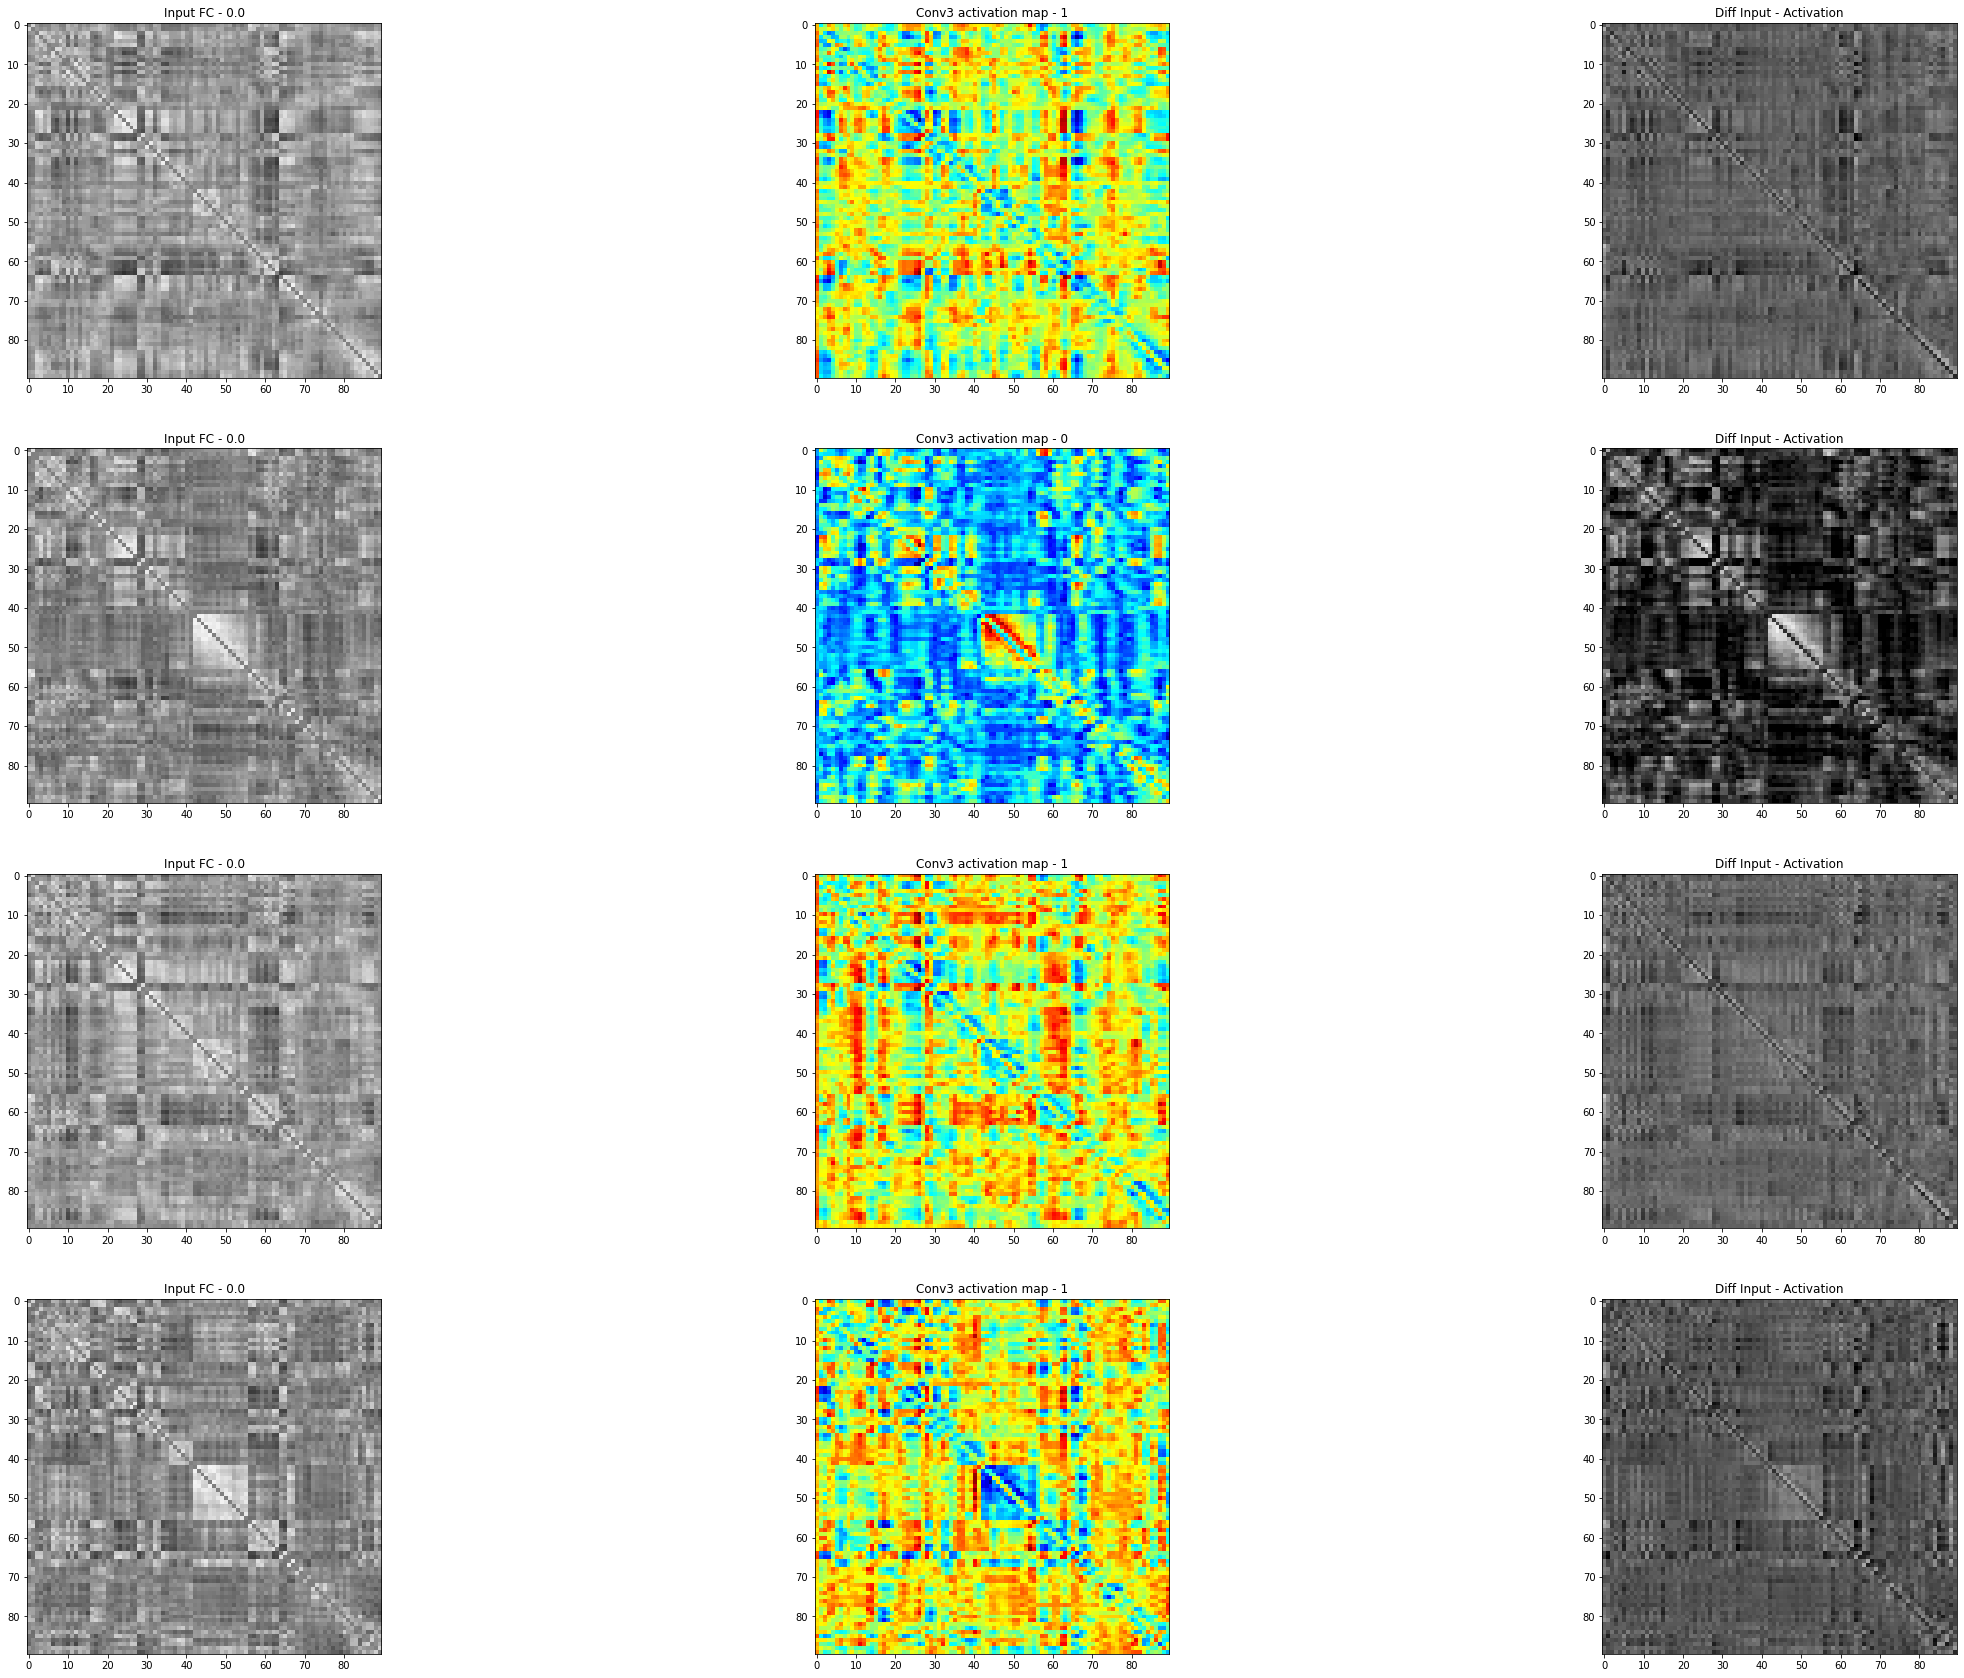

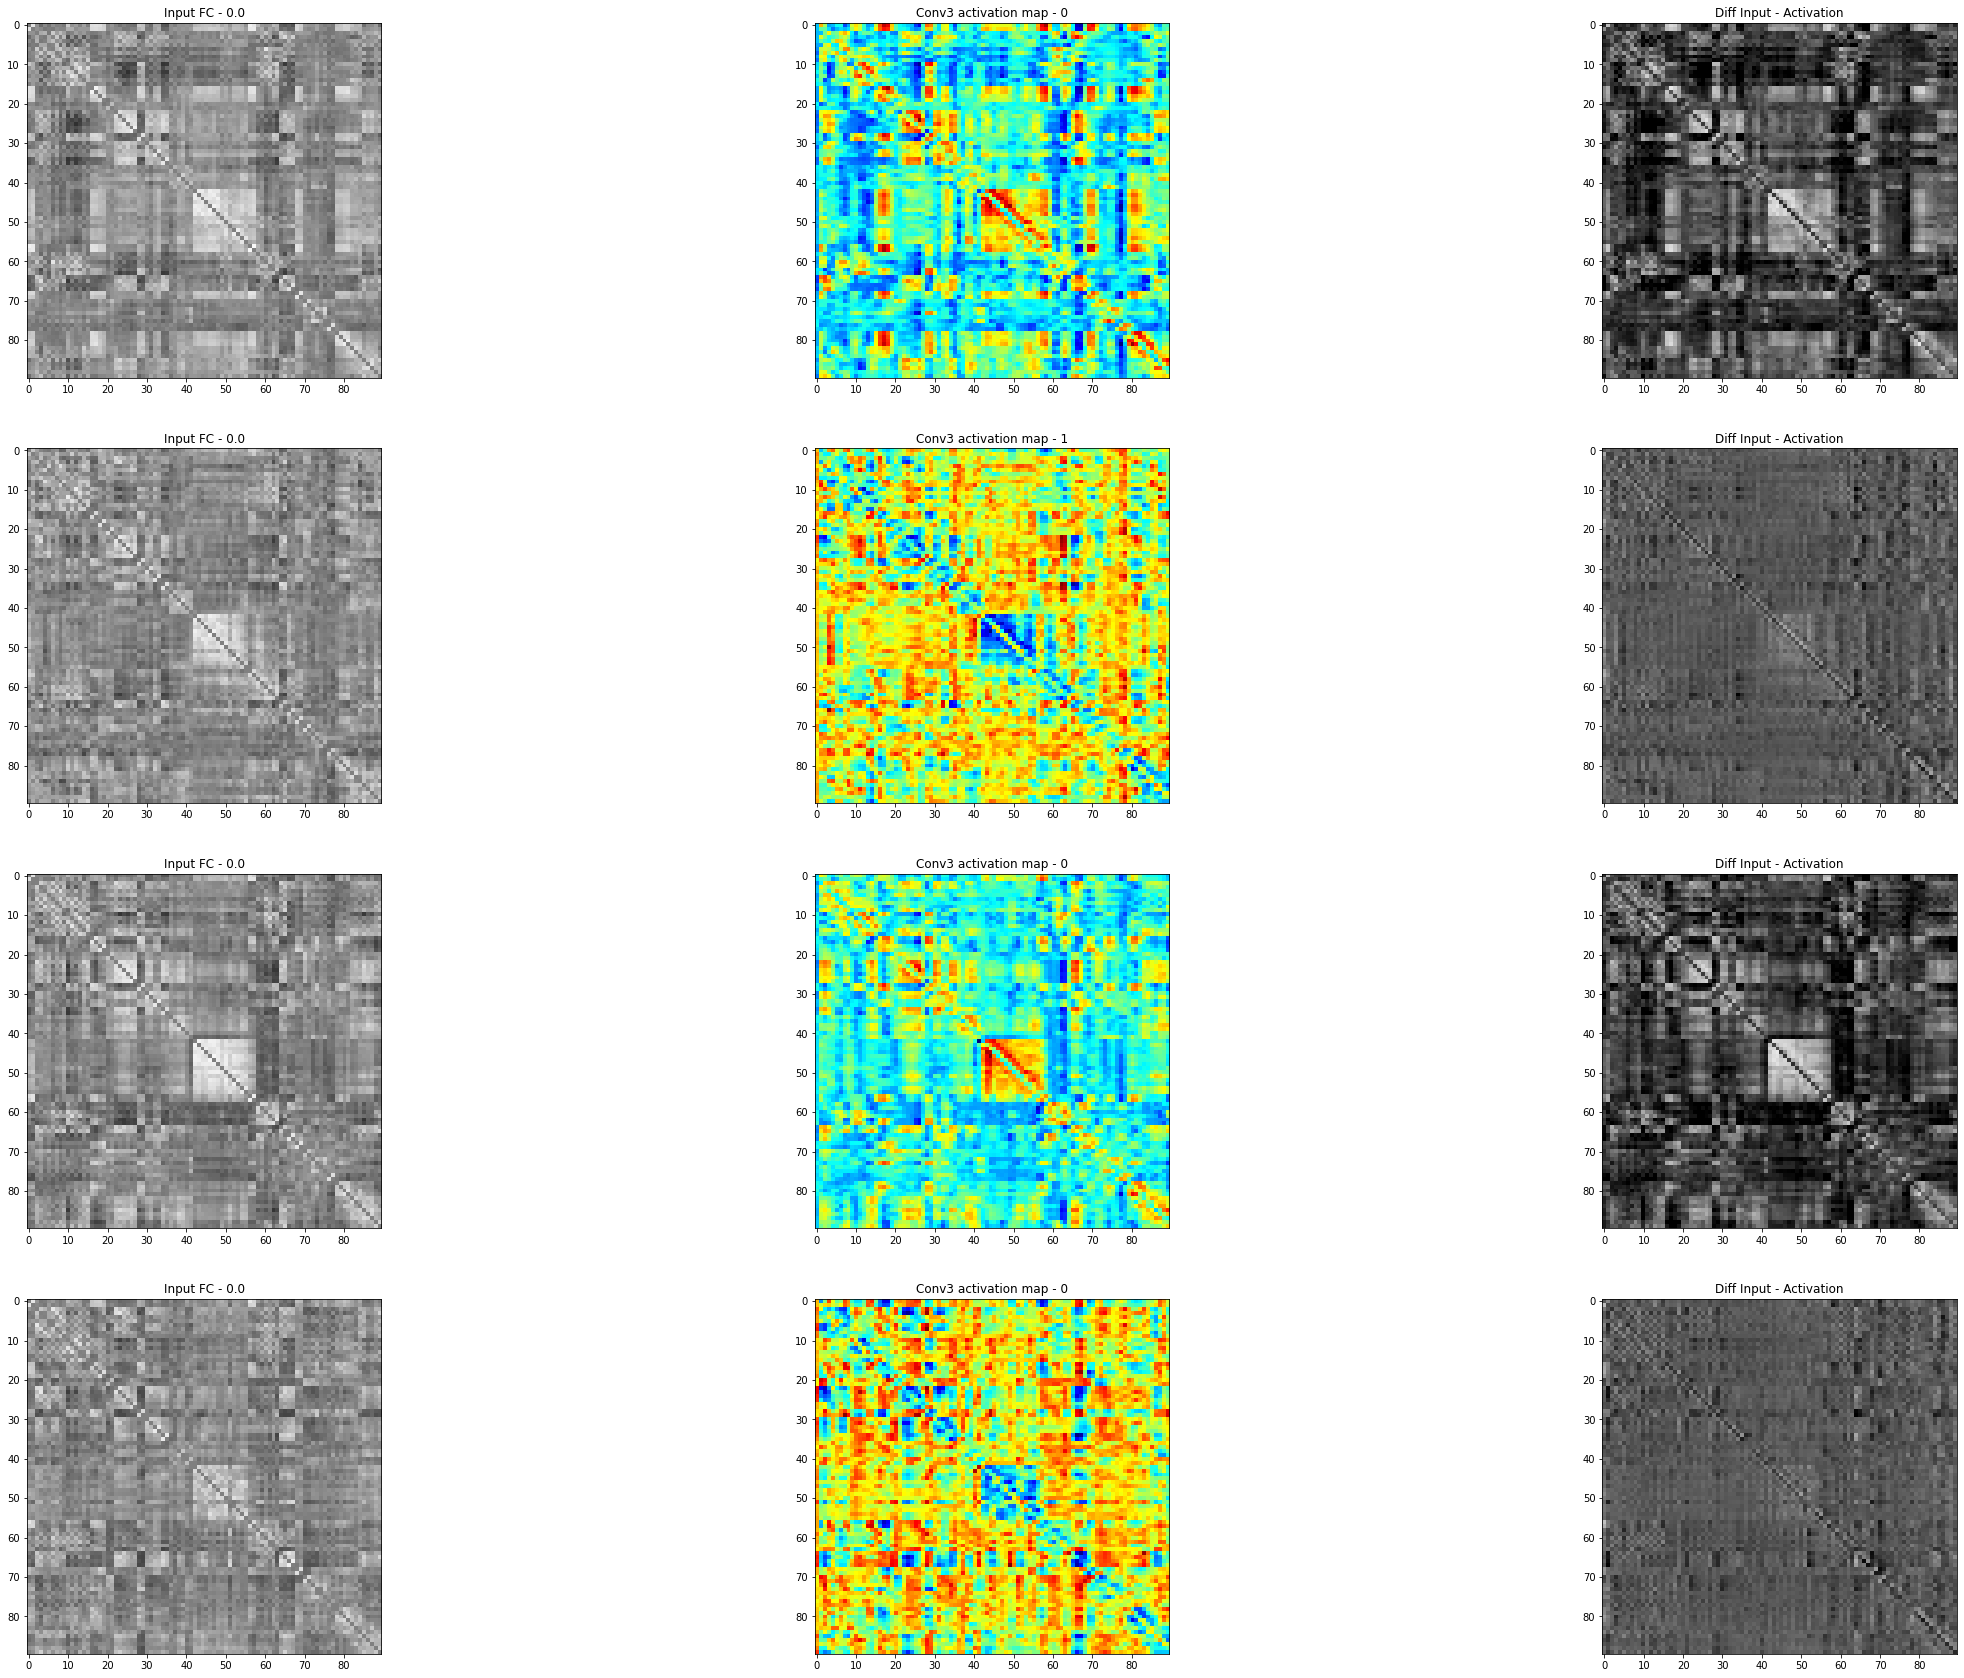

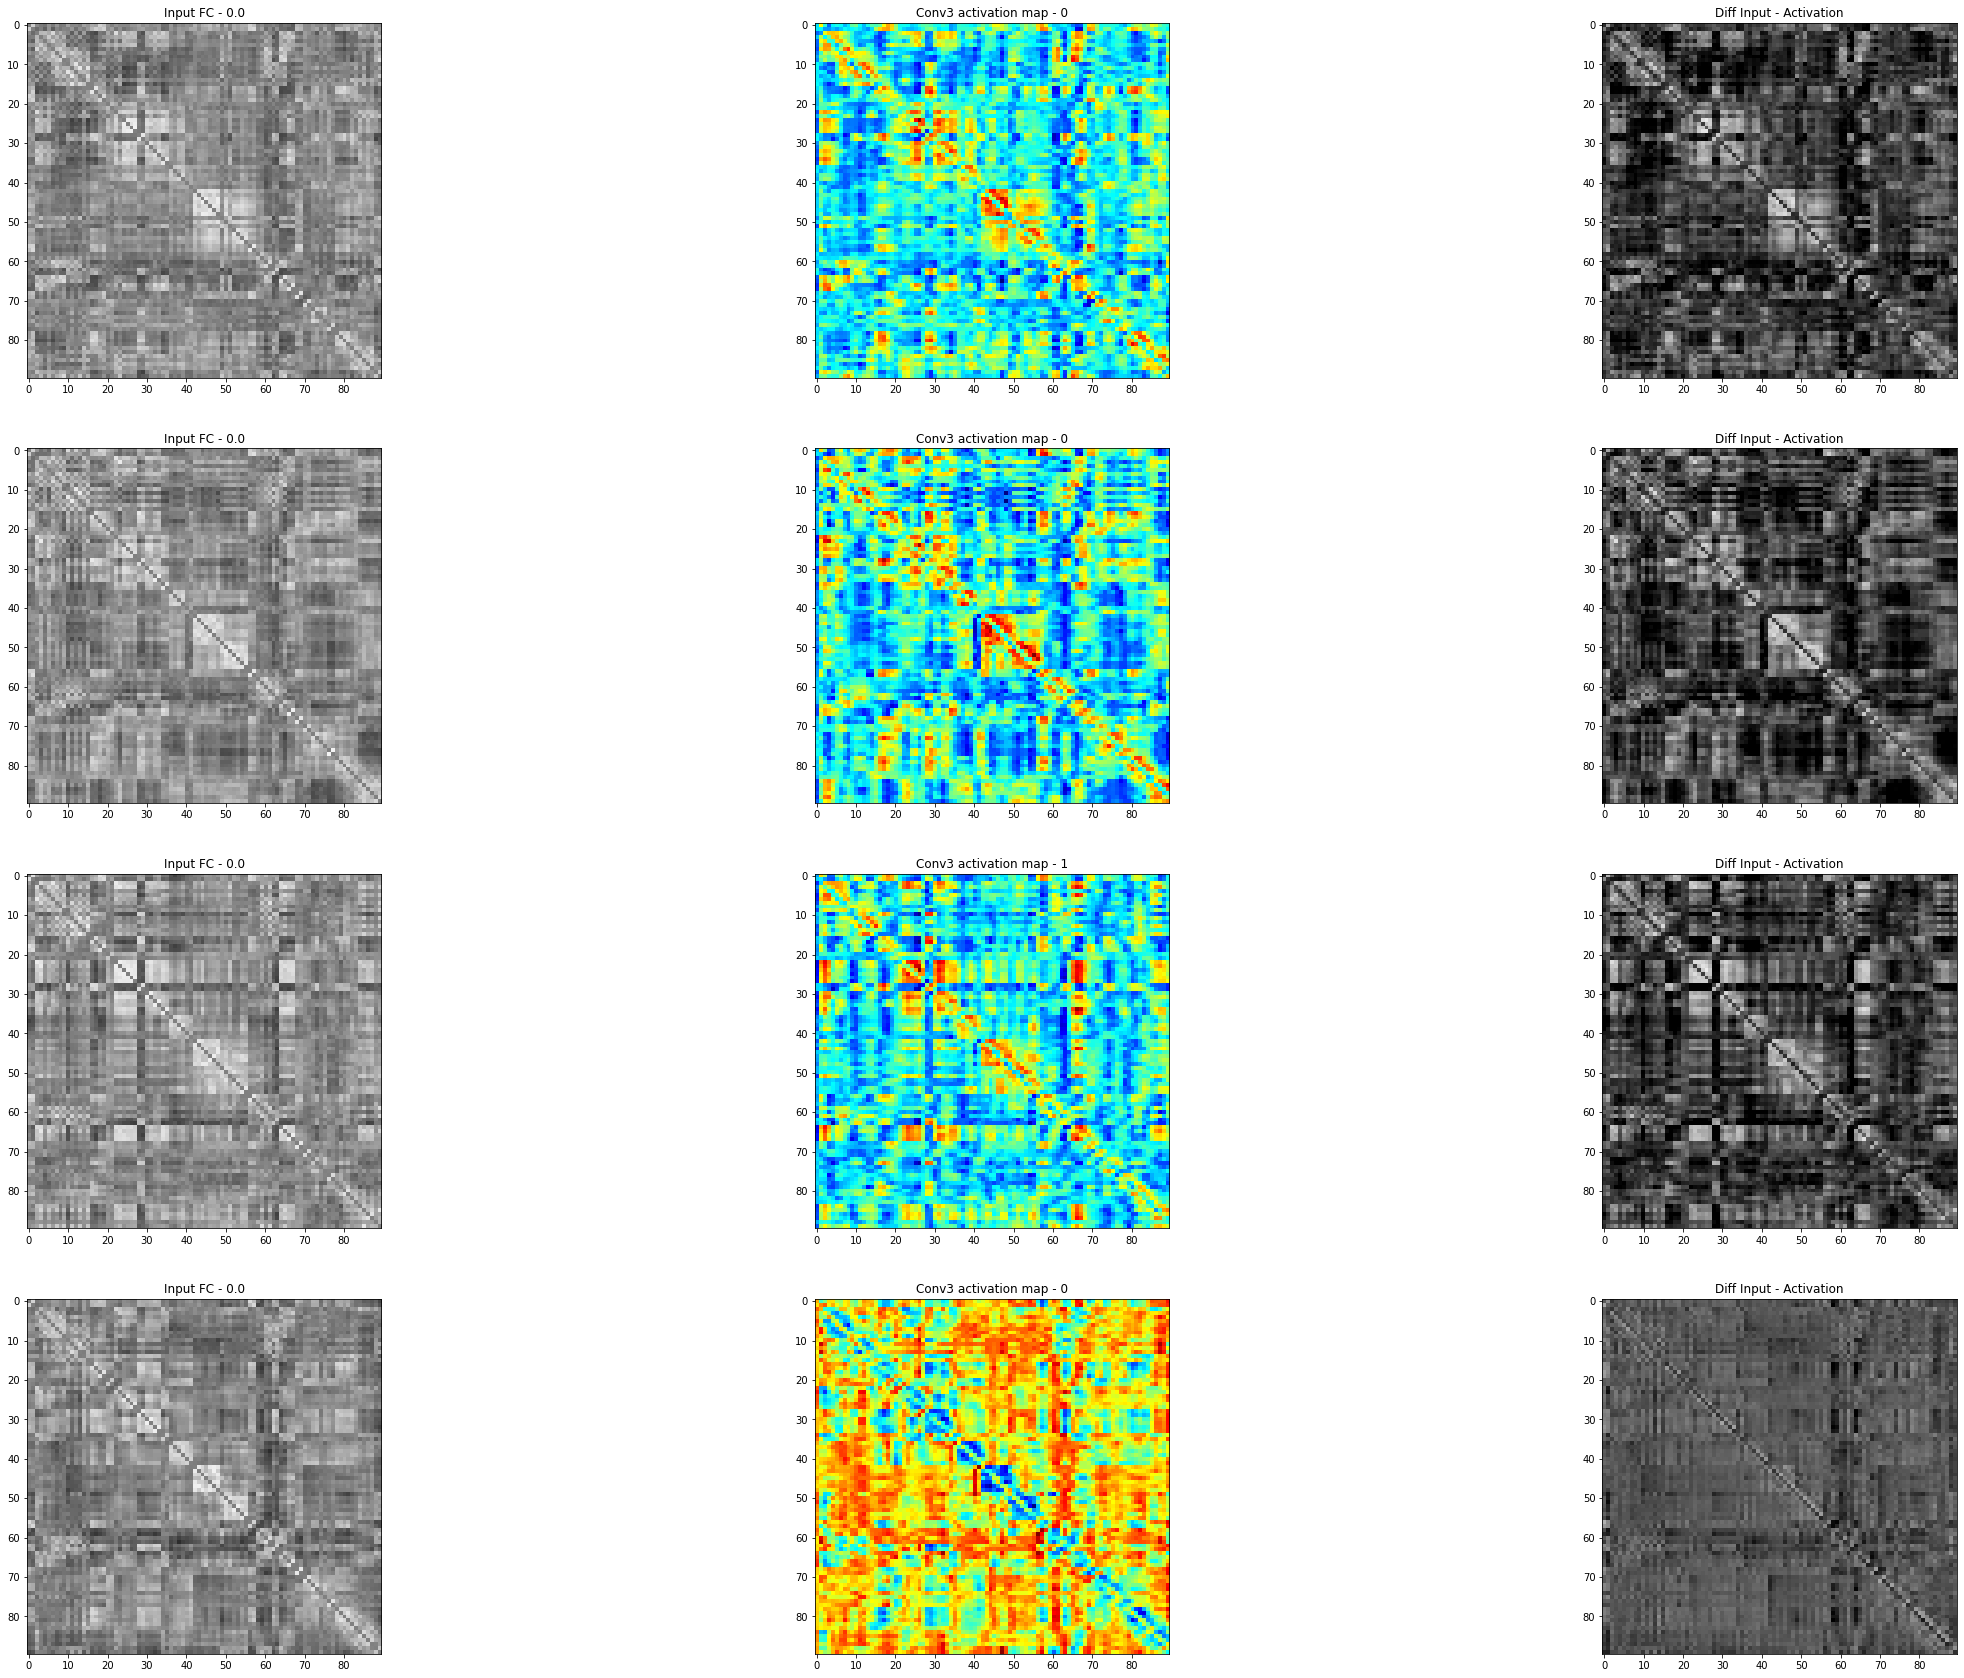

In [95]:
for i in range(3):
    batch = next(val_data_iterator) 
    input_tensors = batch[0]
    input_labels = batch[1]

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    target_category = input_labels.type(torch.bool)
    grayscale_cam = cam(input_tensor=input_tensors, target_category=input_labels.squeeze(-1).to(torch.long))

    # Get predictions.
    outputs = net(input_tensors)
    predicted = torch.where(outputs[:,0] < outputs[:,1], 1, 0)

    # Visualize.
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(40, 30))
    for index_cam, image_cam in enumerate(grayscale_cam):
        input_fc = input_tensors[index_cam].cpu().reshape(90, 90)
        input_label = input_labels[index_cam].item()
        visualization = show_cam_on_image(np.zeros(shape=(90,90,3)), image_cam)

        ax[index_cam][0].imshow(input_fc, cmap='gray', vmin=-1, vmax=1)
        ax[index_cam][0].set_title(f'Input FC - {input_label}')
        ax[index_cam][1].imshow(visualization)
        ax[index_cam][1].set_title(f'Conv3 activation map - {predicted[index_cam].item()}')
        ax[index_cam][2].imshow(input_fc - image_cam, cmap='gray', vmin=-1, vmax=1)
        ax[index_cam][2].set_title('Diff Input - Activation')

    plt.show()

## Model evalutation

### Only run on test data when the model has been fully trained and best architecture and other settings have been selected.

In [425]:
tp, tn, fp, fn = 0, 0, 0, 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)

        predicted = torch.where(outputs.view(-1) > 0.5, 1, 0)

        total += labels.size(0)

        labels = labels.view(-1)

        pred_positives = predicted == 1
        label_positives = labels == 1

        tp += (pred_positives & label_positives).sum().item()
        tn += (~pred_positives & ~label_positives).sum().item()
        fp += (pred_positives & ~label_positives).sum().item()
        fn += (~pred_positives & label_positives).sum().item()

print(f'Accuracy: {(tp + tn) / total * 100:.2f} %')
print(f'Precision: {tp / (tp + fp) * 100:.2f} %')
print(f'Recall: {tp / (tp + fn) * 100:.2f} %')
print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')

Accuracy: 78.00 %
Precision: 81.82 %
Recall: 72.00 %
TP: 18, TN: 21, FP: 4, FN: 7
